# Sign Language Recognition

Dalang Felix Sihitshuwam \
Email: f.dalang@innopolis.university

Otobong Jerome Bassey \
Email: o.jerome@innopolis.university

Briefly, in this task, we seek to develop and train a model which classifies hand signs.

# Data Loading and Preprocessing.

In [ ]:
import os
import cv2
import glob
import numpy as np
import pandas as pd

from google.colab.patches import cv2_imshow
from IPython.display import clear_output

In [ ]:
if not 'train_data' in os.listdir():
  !unzip ./drive/MyDrive/DataSet/asl_alphabet_train.zip -d train_data
  clear_output()

if not 'test_data' in os.listdir():
  !unzip ./drive/MyDrive/DataSet/asl_alphabet_test.zip -d test_data
  clear_output()

Train Data Preview

J ./train_data/asl_alphabet_train/J/J1531.jpg


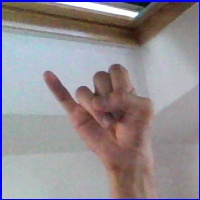

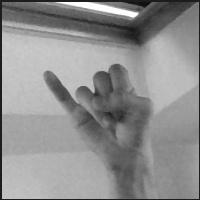

In [ ]:
import random
letter = random.choice(os.listdir('./train_data/asl_alphabet_train/'))
img_path = f'./train_data/asl_alphabet_train/{letter}/'
image_path = random.choice([i for i in glob.glob(f"{img_path}*.jpg")])
print(letter, image_path)
image = cv2.imread(image_path)
gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
cv2_imshow(image)
cv2_imshow(gray)


Test Data Preview

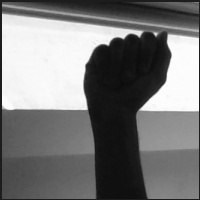

./test_data/asl_alphabet_test/A_test.jpg


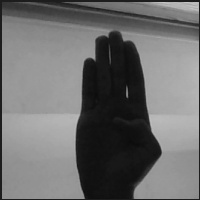

./test_data/asl_alphabet_test/B_test.jpg


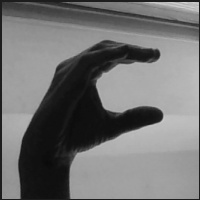

./test_data/asl_alphabet_test/C_test.jpg


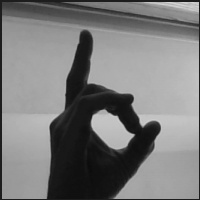

./test_data/asl_alphabet_test/D_test.jpg


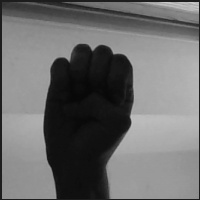

./test_data/asl_alphabet_test/E_test.jpg


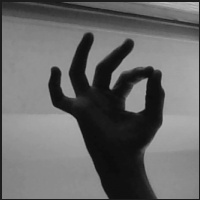

./test_data/asl_alphabet_test/F_test.jpg


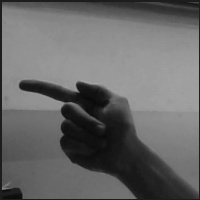

./test_data/asl_alphabet_test/G_test.jpg


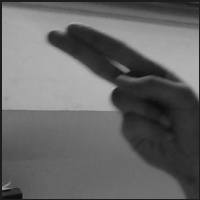

./test_data/asl_alphabet_test/H_test.jpg


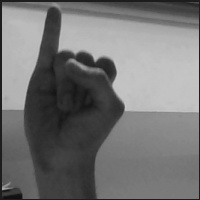

./test_data/asl_alphabet_test/I_test.jpg


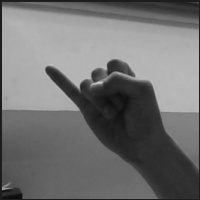

./test_data/asl_alphabet_test/J_test.jpg


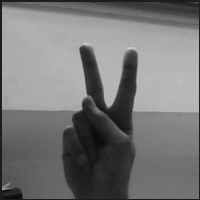

./test_data/asl_alphabet_test/K_test.jpg


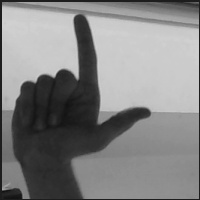

./test_data/asl_alphabet_test/L_test.jpg


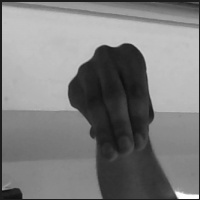

./test_data/asl_alphabet_test/M_test.jpg


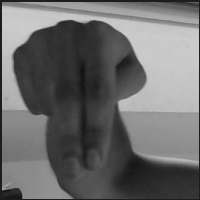

./test_data/asl_alphabet_test/N_test.jpg


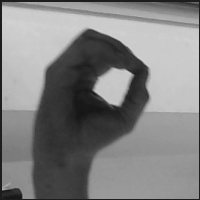

./test_data/asl_alphabet_test/O_test.jpg


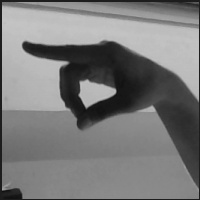

./test_data/asl_alphabet_test/P_test.jpg


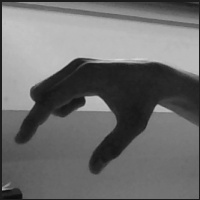

./test_data/asl_alphabet_test/Q_test.jpg


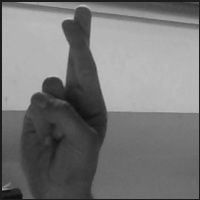

./test_data/asl_alphabet_test/R_test.jpg


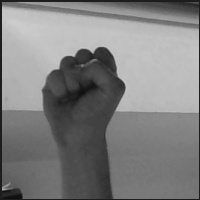

./test_data/asl_alphabet_test/S_test.jpg


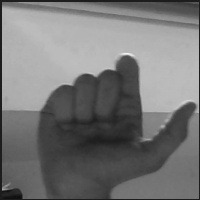

./test_data/asl_alphabet_test/T_test.jpg


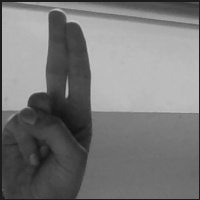

./test_data/asl_alphabet_test/U_test.jpg


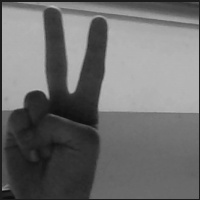

./test_data/asl_alphabet_test/V_test.jpg


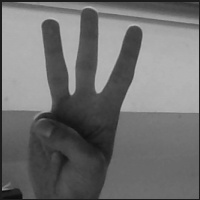

./test_data/asl_alphabet_test/W_test.jpg


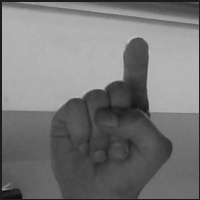

./test_data/asl_alphabet_test/X_test.jpg


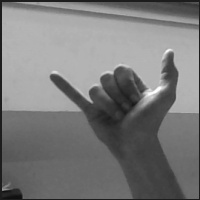

./test_data/asl_alphabet_test/Y_test.jpg


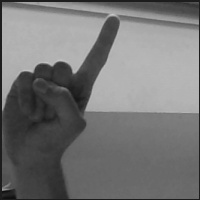

./test_data/asl_alphabet_test/Z_test.jpg


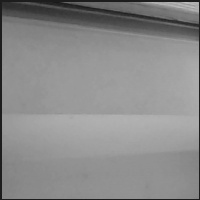

./test_data/asl_alphabet_test/nothing_test.jpg


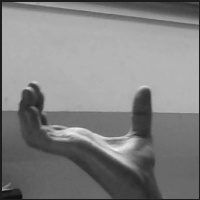

./test_data/asl_alphabet_test/space_test.jpg


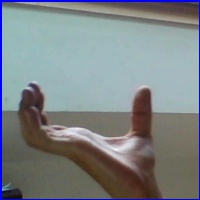

In [ ]:
img_folder = "./test_data/asl_alphabet_test/"
images = sorted([i for i in glob.glob(f"{img_folder}*.jpg")])
# img_path = random.choice(images)
for img_path in images:
  gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
  cv2_imshow(gray)
  print(img_path)

image = cv2.imread(img_path)
cv2_imshow(image)

In [ ]:
labels_dict = dict([(j.split('_')[0], i) for i, j in enumerate(sorted(os.listdir('./train_data/asl_alphabet_train/')))])
print(labels_dict)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}


# Model Design and Training

In [ ]:
import glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

In [ ]:
class CustomDataset(Dataset):
  """"""
  def __init__(self, labels_dict, img_dir, transform=None, target_transform=None):
      self.labels_dict = labels_dict
      self.img_dir = img_dir
      self.images = [i for i in glob.glob(f"{img_dir}*.jpg")]
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_path = self.images[idx]
      fname = os.path.basename(img_path)
      label = self.labels_dict[fname.split('_')[0]]
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(label)
      return image, label
  
class TrainDataset(Dataset):
  """"""
  def __init__(self, labels_dict, img_dir, transform=None, target_transform=None, test=False):
      self.labels_dict = labels_dict
      self.img_dir = img_dir
      self.images = []
      for j in sorted(os.listdir(img_dir)):
        self.images.extend([(i, j) for i in glob.glob(f"{img_dir}/{j}/*.jpg")])
        # if test:
        #   self.images.extend([(i, j) for i in glob.glob(f"{img_dir}/{j}/*.jpg")[2400:]])
        # else:
        #   self.images.extend([(i, j) for i in glob.glob(f"{img_dir}/{j}/*.jpg")[:2400]])
      self.transform = transform
      self.target_transform = target_transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
      img_path, letter = self.images[idx]
      label = self.labels_dict[letter]
      image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      if self.transform:
          image = self.transform(image)
      if self.target_transform:
          label = self.target_transform(label)
      return image, label

In [ ]:
test_data = CustomDataset(
    labels_dict=labels_dict,
    img_dir="./test_data/asl_alphabet_test/",
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(len(labels_dict), dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [ ]:
train_data = TrainDataset(
    labels_dict=labels_dict,
    img_dir="./train_data/asl_alphabet_train/",
    transform=transforms.ToTensor(),
    target_transform=transforms.Lambda(lambda y: torch.zeros(len(labels_dict), dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

In [ ]:
sample_idx = torch.randint(len(test_data), size=(1,)).item()
img, label = test_data[sample_idx]
print(test_data.images[sample_idx])
print(label)

('./train_data/asl_alphabet_train//I/I949.jpg', 'I')
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
print(len(train_data), len(test_data))
sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, label = train_data[sample_idx]
print(train_data.images[sample_idx][1])
print(label)

69600 17400
C
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
batch_size = 100
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=100, shuffle=True)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


Methods For Training and Testing

In [ ]:
#CNN Network

class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        # b = 64 # batchsize
        #Input shape= (b,1,200,200)
        
        self.conv1=nn.Conv2d(in_channels=1,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (b,12,200,200)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (b,12,200,200)
        self.relu1=nn.ReLU()
        #Shape= (b,12,200,200)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (b,12,100,100)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (b,20,100,100)
        self.relu2=nn.ReLU()
        #Shape= (b,20,100,100)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (b,32,100,100)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (b,32,100,100)
        self.relu3=nn.ReLU()
        #Shape= (b,32,100,100)
        
        
        self.fc=nn.Linear(in_features=100 * 100 * 32,out_features=num_classes)
        
        
        
        #Feed forward function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
        #Above output will be in matrix form, with shape (b,32,100,100)
            
        output=output.view(-1,32*100*100)
            
        output=self.fc(output)
            
        return output

In [ ]:
model=  ConvNet(num_classes=len(labels_dict)).to(device)
#Optmizer and loss function
optimizer= torch.optim.Adam(model.parameters(),lr=0.01,weight_decay=0.001)
loss_function=nn.CrossEntropyLoss()

#Model training and saving best model

best_accuracy=0.0
num_epochs = 5

train_count = len(train_dataloader)
test_count = len(test_dataloader)

for epoch in range(num_epochs):
    
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    total = len(train_dataloader)
    for i, (images,labels) in enumerate(train_dataloader):
        if torch.cuda.is_available():
            images = torch.autograd.Variable(images.cuda())
            labels = torch.autograd.Variable(labels.cuda())
            
        optimizer.zero_grad()
        
        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()
        
        
        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)
        _, labels_ = torch.max(labels.data,1)
        train_accuracy+=int(torch.sum(prediction==labels_))
        if i%100 ==0:
          print(f"{i}/{total}", train_accuracy)
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    # Evaluation on testing dataset
    model.eval()
    
    test_accuracy=0.0
    for i, (images,labels) in enumerate(test_dataloader):
        if torch.cuda.is_available():
            images=torch.autograd.Variable(images.cuda())
            labels=torch.autograd.Variable(labels.cuda())
            
        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        _, labels_ = torch.max(labels.data,1)
        # print(outputs.shape, labels.shape)
        test_accuracy+=int(torch.sum(prediction==labels_))
    
    test_accuracy=test_accuracy/test_count
    
    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))
    
    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model,'model.model')
        best_accuracy=test_accuracy
        print(f"Best accuracy {best_accuracy}")
    

# Reference

[1](https://github.com/gaurav67890/Pytorch_Tutorials/blob/master/cnn-scratch-training.ipynb), with much gratitude.